# 基于神经算子网络的涡轮级流场预测与不确定性优化设计

## 概述

流体机械在设计、加工制造和运行的过程中存在诸多的不确定性，会导致实际运行时流量、效率等总体参数偏离设计值，对运行性能造成影响。然而将几何与工况的不确定性纳入设计的考量又会使得设计过程中性能综合评估的成本与耗时急剧增加，当前流体机械领域缺乏低成本的不确定性优化设计方法。
将高精度神经算子网络应用到不确定性优化设计中，作为耗时的CFD计算的代替品是解决上述的问题的一类方法，可以有效提升不确定性优化设计的效率，增强设计对象的运行稳定性。

## 方法

### 问题描述

在以CFD数值计算为评估手段进行优化设计时，直接使用蒙特卡洛方法计算特定设计方案在不确定性输入下的性能分布的成本极大。传统的不确定性优化设计往往采用基于代理模型的不确定性量化方法，例如混沌多项式来完成不确定性参数的评估，但即使如此在对一个样本进行评估时也需要完成数十上百次的数值计算。

### 技术路径

本文采用了蒙特卡洛结合深度学习的方法来完成不确定性的量化评估。并基于此评估结果完成优化设计，具体流程如下图所示：
1.  NSGA2算法输出需要计算的$n$个设计方案的变量信息；
2.  使用ITS方法获取不确定性输入的$m$个离散化表示；
3.  组合设计变量与不确定性变量，使用深度学习模型计算得到$m \times n$个物理场结果；
4.  对物理场结果进行后处理获得性能参数结果；
5.  完成不确定性量化计算，获得$n$个设计的不确定性评估并返回到算法模块；
6.  重复上述5个步骤，直到$h$次迭代结束输出最优解；

<div align="center">
<img alt="UQ_optimization" src="./images/UQ_optimization_EN.png" width="500"/>
<div align="left">

在上述过程中，对于设计方案的全物理场评估是关键，一次优化设计共需要完成$m \times n \times h$次评估，以传统的CFD数值计算的成本完全无法接受，因此需要计算快速，方便并行的神经网络来完成物理场的预测，同时要求有较高的预测精度。
基于神经网络的物理场预测是上述整个流程的核心步骤。其具体网络结构如下：

<div align="center">
<img alt="trans_operator_gvrb" src="./images/trans_operator_gvrb.png" width="500"/>
<div align="left">

1.  深度算子网络的输入包括：设计参数$\bf{x}$、工况参数$\alpha$、坐标参数$p$，三者在连接后输入网络。
2.  本文所采用的网络结构为使用galerkin线性计算的transformer算子网络；
3.  网络的输出为基础物理场，包括有：压力$P$、温度$T$、速度$V$（三个分量）、密度$\rho$这些N-S方程求解的基本特征量，每个特征量占据一个通道；
4.  当获取的结果具有所有N-S方向的特征物理量时，可以基于后处理程序计算任意的物理场或性能参数值。


In [1]:
import os
import time
import argparse

from omegaconf import OmegaConf
import numpy as np
from mindspore import dtype as mstype
from mindspore import ops, context, set_seed, save_checkpoint
from mindspore.amp import DynamicLossScaler, auto_mixed_precision
from mindflow.loss import RelativeRMSELoss
from mindflow.utils import load_yaml_config, print_log

set_seed(0)
np.random.seed(0)

### 设置超参数

定义一系列训练超参数，包括：运行模型，运行设备，超参数文件路径等。
大部分网络训练超参数在config.yaml文件中定义。


In [2]:
def parse_args():
    """Parse input args"""
    parser = argparse.ArgumentParser(description="gvrb predict")
    parser.add_argument("--mode", type=str, default="PYNATIVE",
                        choices=["GRAPH", "PYNATIVE"], help="Running in GRAPH_MODE OR PYNATIVE_MODE")
    parser.add_argument("--device_target", type=str, default="Ascend", choices=["GPU", "Ascend", "CPU"],
                        help="The target device to run, support 'Ascend', 'GPU', 'CPU'")
    parser.add_argument("--device_id", type=int, default=1,
                        help="ID of the target device")
    parser.add_argument("--config_file_path", type=str,
                        default="configs/UNet_GVRB.yaml")
    input_args = parser.parse_args(args=[])
    return input_args

args = parse_args()
context.set_context(
    mode=context.GRAPH_MODE if args.mode.upper().startswith("GRAPH") else context.PYNATIVE_MODE, device_target=args.device_target, device_id=args.device_id)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
compute_type = mstype.float16 if use_ascend else mstype.float32

### 导入配置文件

在训练超参数中包含了config文件的路径，通过该路径读取配置文件。
文件中包含了训练的具体参数，如学习率、迭代次数、模型结构等。


In [34]:
from src import init_record
config = OmegaConf.create(load_yaml_config(args.config_file_path))
record = init_record(use_ascend, args, config, record_name='gvrb_train')

Configuration:
model_type: unet
unet:
  in_channels: 100
  out_channels: 8
  channels: 20
  load_ckpt: none
data:
  path: ./data
  num_samples:
    train: 2000
    test: 500
train:
  batch_size: 32
  lr_init: 0.0001
  epochs: 500
  optimizer: Adam
  weight_decay: 0.0
  lr_scheduler:
    type: cos
    enable_warmup: true
    warmup_epochs: 10
test:
  batch_size: 10
  interval: 50
record_path: exp/GVRB

Pid: 64222
Use Ascend: True


### 创建数据集

本文以GE-E3第一级高压涡轮为研究对象建立性能评估模型，GE-E3高压级单通道模型如下所示。其中包含一列静叶S1和一列动叶R1。数值计算使用商业CFD软件Numeca完成。

<div align="center">
<img alt="GEE3_blade.png" src="./images/GEE3_blade.png" width="400"/>
<div align="left">

本文制备数据集如下图所示，在数据准备过程中，采用拉丁超立方采样(LHS)方法，对共计100个几何与边界条件设计变量 的问题在设计空间中采集了4900个样本。随后，使用几何参数化方法生成相应的几何模型，并计算每个样本的三维流场。最后，随机选取其中4000个样本为训练集，900个样本为验证集。

<div align="center">
<img alt="gvrb_data_prepare" src="./images/gvrb_data_prepare_EN.png" width="500"/>
<div align="left">

使用loaddataset函数将数据集加载到内存中，并返回数据加载器。同时手动保存归一化参数对象


In [35]:
from src import load_dataset
print_log("Loading data...")
data_loader_train, data_loader_test = load_dataset(config, save_path=record.npz_dir)

Loading data...


### 构建模型

本文对于网络类型并无特定要求，默认使用UNet或FNO网络，在config文件中定义网络具体参数。


In [36]:
from src import get_model
model = get_model(config, compute_type)

### 优化器及损失函数

损失函数使用均方误差，优化器使用Adam优化器。
具体定义在config文件中。


In [37]:
from src import get_optimizer
loss_fn = RelativeRMSELoss(reduction='mean')
steps_per_epoch = data_loader_train.get_dataset_size()
optimizer = get_optimizer(model, config, steps_per_epoch)
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')

### 训练函数

定义前向传播函数forward_fn, 将预测值与真值比较得到loss。


In [38]:
def forward_fn(inputs, outputs):
    inputs = inputs.astype(dtype=compute_type)
    outputs = outputs.astype(dtype=compute_type)
    pred = model(inputs)
    loss = loss_fn(pred, outputs)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, pred
    
grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(inputs, output):
        inputs = repeat_tensor(inputs)
        (loss, pred), grads = grad_fn(inputs, output)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            grads = loss_scaler.unscale(grads)
        loss = ops.depend(loss, optimizer(grads))
        return loss, pred

### 模型训练

在训练开始前以及每训练25个epoch后，都会对训练集和测试集计算误差，具体使用test函数完成。
训练中，每训练25个epoch后，将模型保存到ckpt文件中。
测试与记录的间隔比例基于config文件参数config.test.interval。


In [39]:
from src import repeat_tensor, test_loop

def train():
    loss_step = {}
    loss_step['train'] = test(data_loader_train, prefix="train", epoch=0)
    loss_step['test'] = test(data_loader_test, prefix="test", epoch=0)

    for epoch in range(1, 1 + config.train.epochs):
        local_time_beg = time.time()
        model.set_train()
        loss_all = []

        for data_tuple in data_loader_train:
            loss, _ = train_step(*data_tuple)
            loss_all.append(loss.asnumpy())

        loss = np.mean(loss_all)
        print_log(f"Epoch {epoch}: loss {loss:>5.3f}")
        epoch_seconds = time.time() - local_time_beg
        step_seconds = epoch_seconds / steps_per_epoch
        print_log(f"Train epoch time: {epoch_seconds:>5.3f} s, per step time: {step_seconds* 1000:>5.3f} ms")

        if epoch % config.test.interval == 0 or epoch == config.train.epochs:
            loss_step['train'].append(test(data_loader_train, prefix="train", epoch=epoch))
            loss_step['test'].append(test(data_loader_test, prefix="test", epoch=epoch))
            save_checkpoint(model, os.path.join(record.ckpt_model))

def test(data_loader, prefix="train", epoch=0):
    '''test and evaluate the network'''
    if not isinstance(data_loader, list):
        data_loader = [data_loader]
    l2_error_list = test_loop(model, data_loader, compute_type=compute_type)
    for l2_error in l2_error_list:
        print_log(f"Epoch {epoch}: {prefix}: {np.array(l2_error).mean()}")
    return l2_error_list

### 训练过程

在启动训练后会首先打印config参数及模型信息。
开始训练后会输出每次迭代loss值。
完成训练后输出训练耗时。
打印内容同步保存到result.log中。


In [11]:
# train
print_log('training...')
start_time = time.time()
train()
print_log("training done!")
print_log(f"Total train time: {time.time() - start_time}s")

training...
Epoch 0: train: 1.1504379197190253
Epoch 0: test: 1.1522167064290412
Epoch 1: loss 1.172
Train epoch time: 21.775 s, per step time: 345.628 ms
Epoch 2: loss 1.152
Train epoch time: 3.424 s, per step time: 54.347 ms
Epoch 3: loss 1.103
Train epoch time: 3.302 s, per step time: 52.407 ms
Epoch 4: loss 0.967
Train epoch time: 3.553 s, per step time: 56.389 ms
Epoch 5: loss 0.730
Train epoch time: 3.379 s, per step time: 53.636 ms
Epoch 6: loss 0.520
Train epoch time: 3.245 s, per step time: 51.516 ms
Epoch 7: loss 0.360
Train epoch time: 3.457 s, per step time: 54.876 ms
Epoch 8: loss 0.283
Train epoch time: 3.324 s, per step time: 52.757 ms
Epoch 9: loss 0.232
Train epoch time: 3.525 s, per step time: 55.948 ms
Epoch 10: loss 0.197
Train epoch time: 3.429 s, per step time: 54.435 ms
Epoch 11: loss 0.171
Train epoch time: 3.376 s, per step time: 53.579 ms
Epoch 12: loss 0.155
Train epoch time: 3.536 s, per step time: 56.121 ms
Epoch 13: loss 0.145
Train epoch time: 3.368 s, pe

### 模型推理

调用run_inference函数可以对设计空间内的任意样本进行预测，并将推理的结果保存为npz文件。
在进行推理时，需要将路径args.config_file_path设置为一个已经完成训练的本地record路径；


In [13]:
from src import DataNormer, load_record, run_inference

print_log("inferencing...")
record = load_record('./exp/GVRB/gvrb_train') #using your local record path
y_norm = DataNormer([], loading=True, save_path=os.path.join(record.npz_dir, 'y_norm.npz'))
run_inference(config, ckpt_file_path=record.ckpt_model,
data_loader=data_loader_train, y_norm=y_norm, save_path=record.train)
run_inference(config, ckpt_file_path=record.ckpt_model,
data_loader=data_loader_test, y_norm=y_norm, save_path=record.test)
print_log("inferencing done!")

inferencing...
inferencing done!


### 结果可视化

进一步可以使用绘图函数run_visualization来可视化推理结果。
由于本文模型推理得到了完备的N-S方程的特征物理量，因此可以指定任意物理量完成输出。
这里选择了流量、压比等常见性能参数和基础物理场进行输出，所以的可指定输出参数详见src.utils.post_process

visualizing...


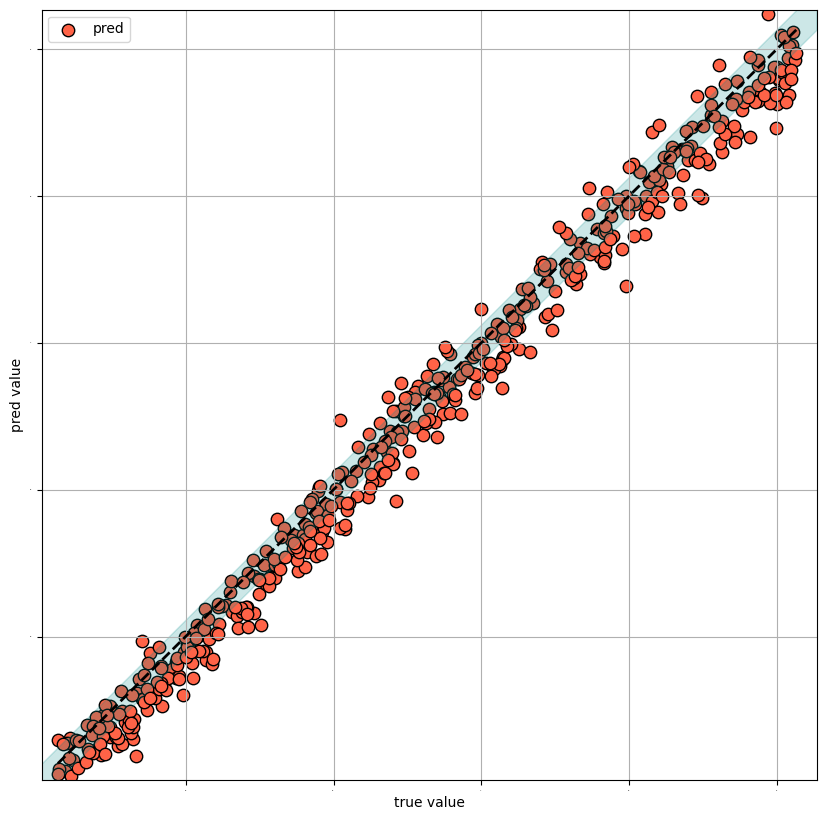

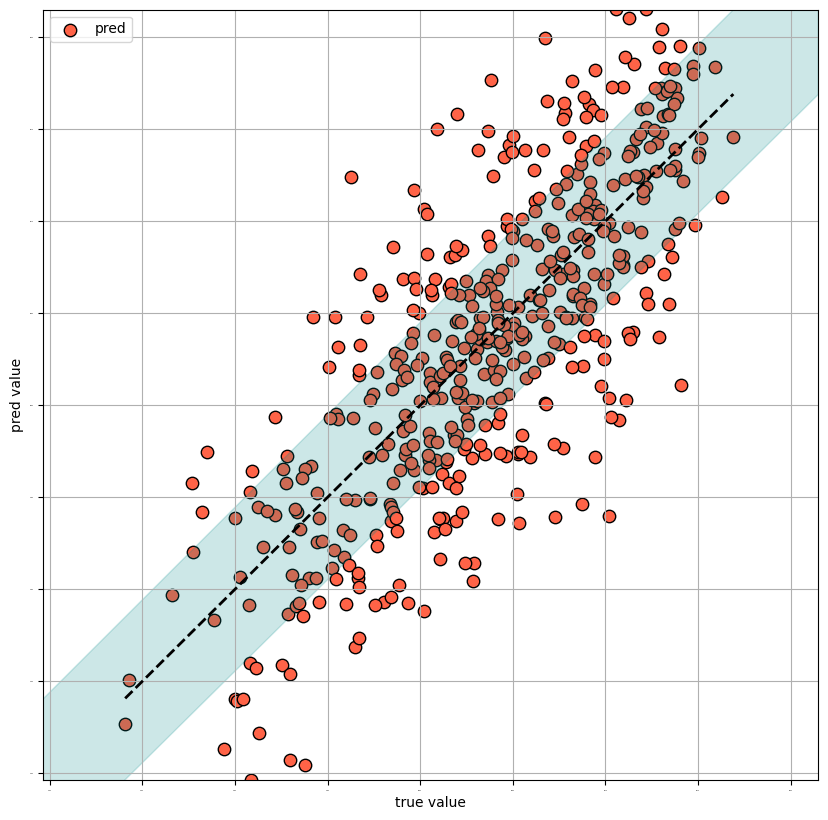

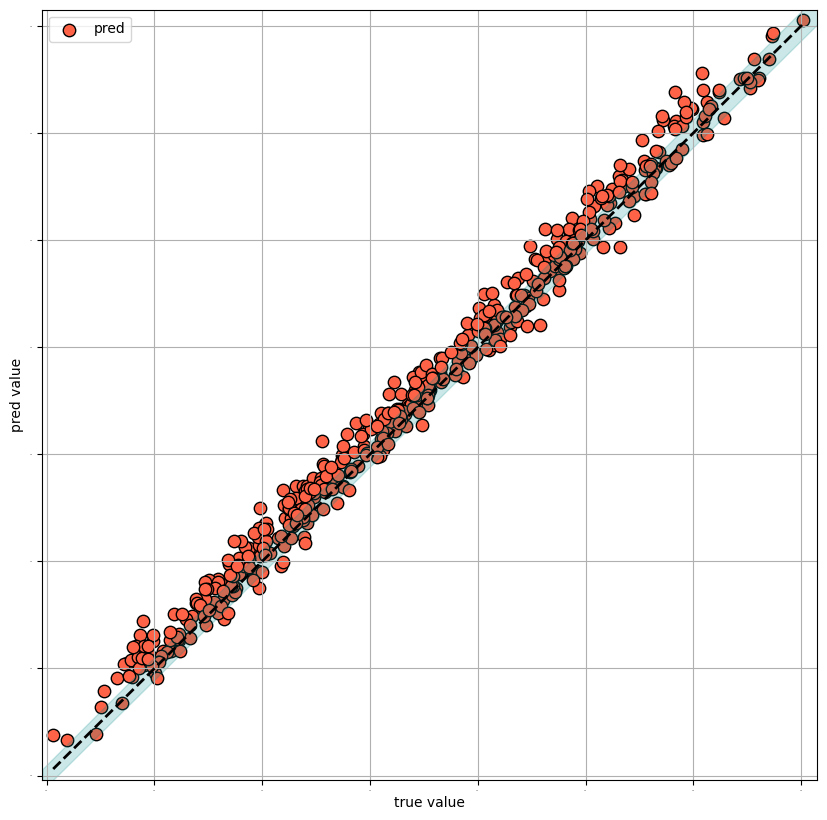

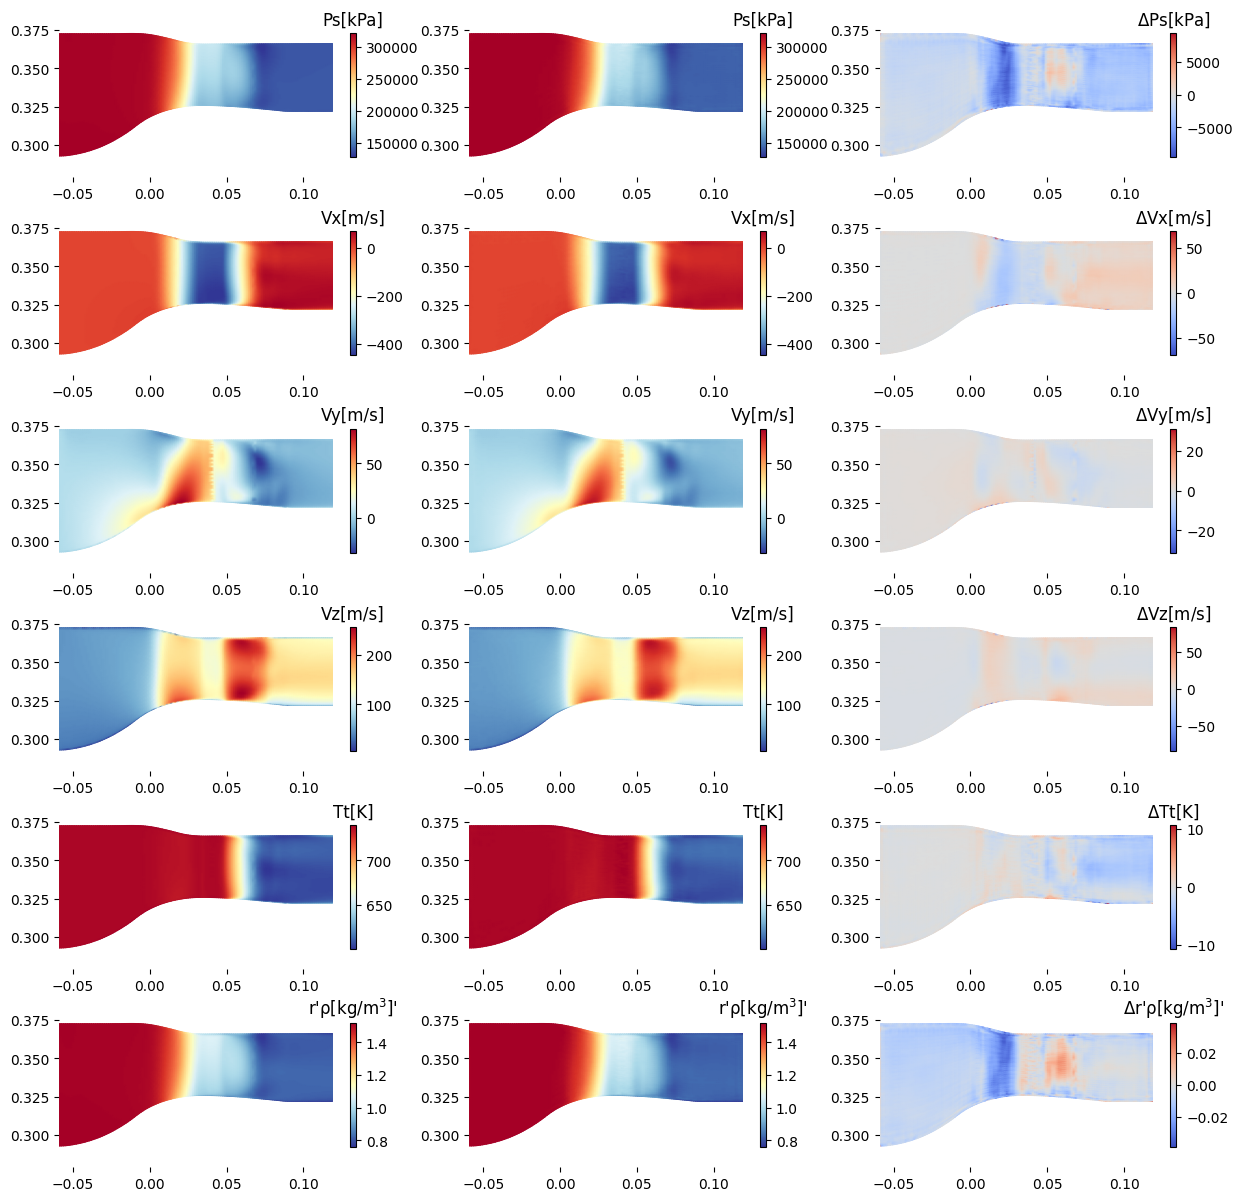

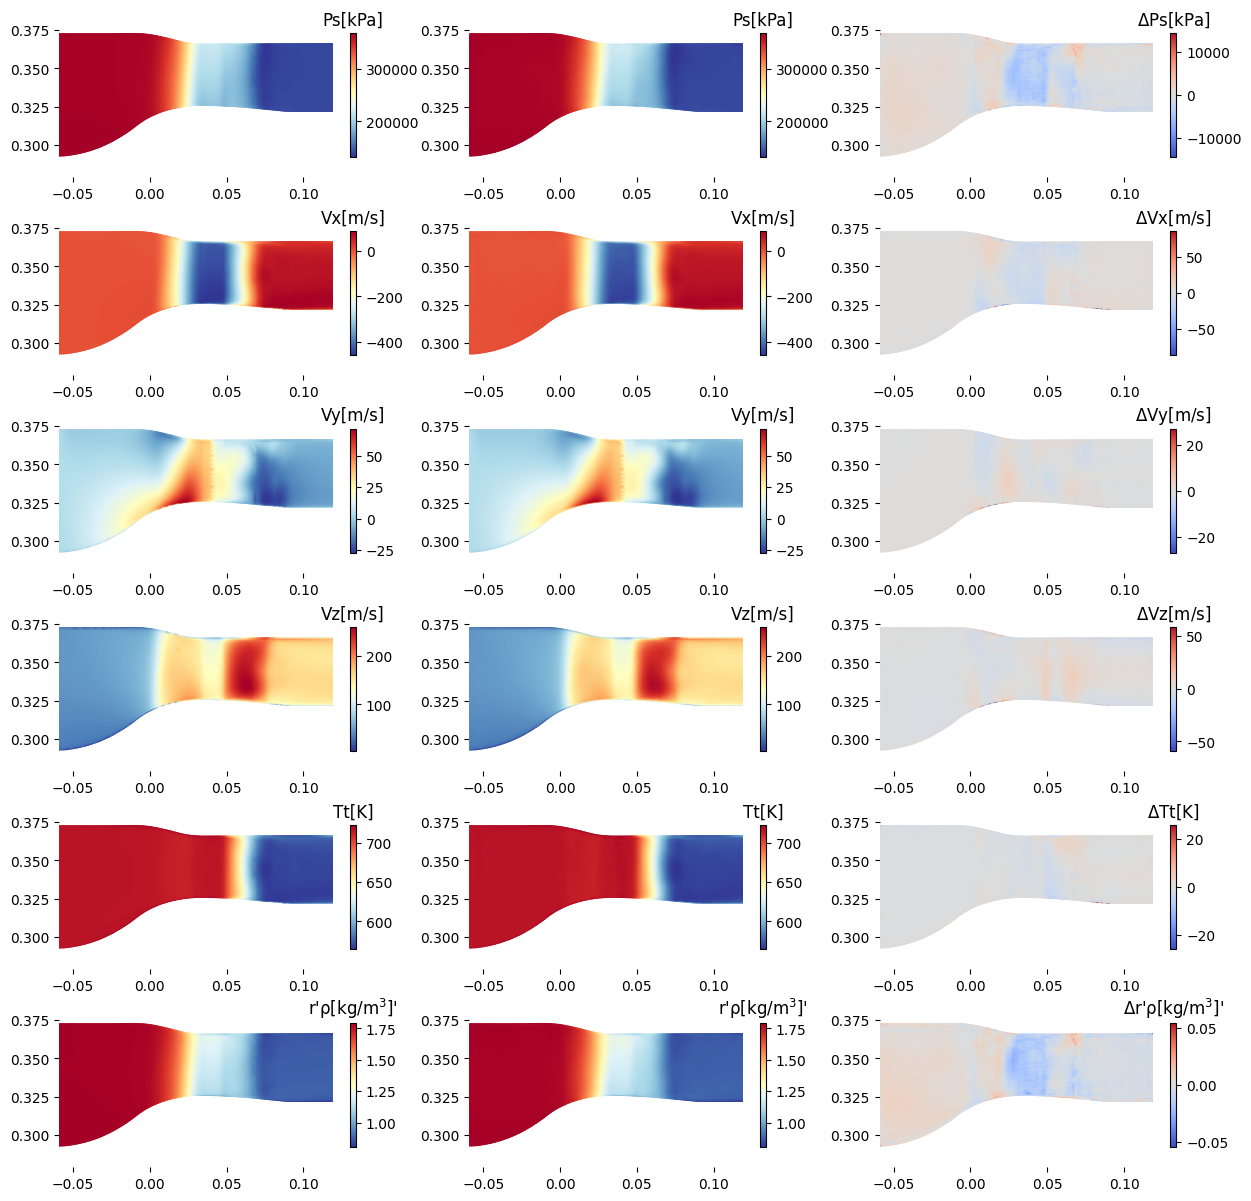

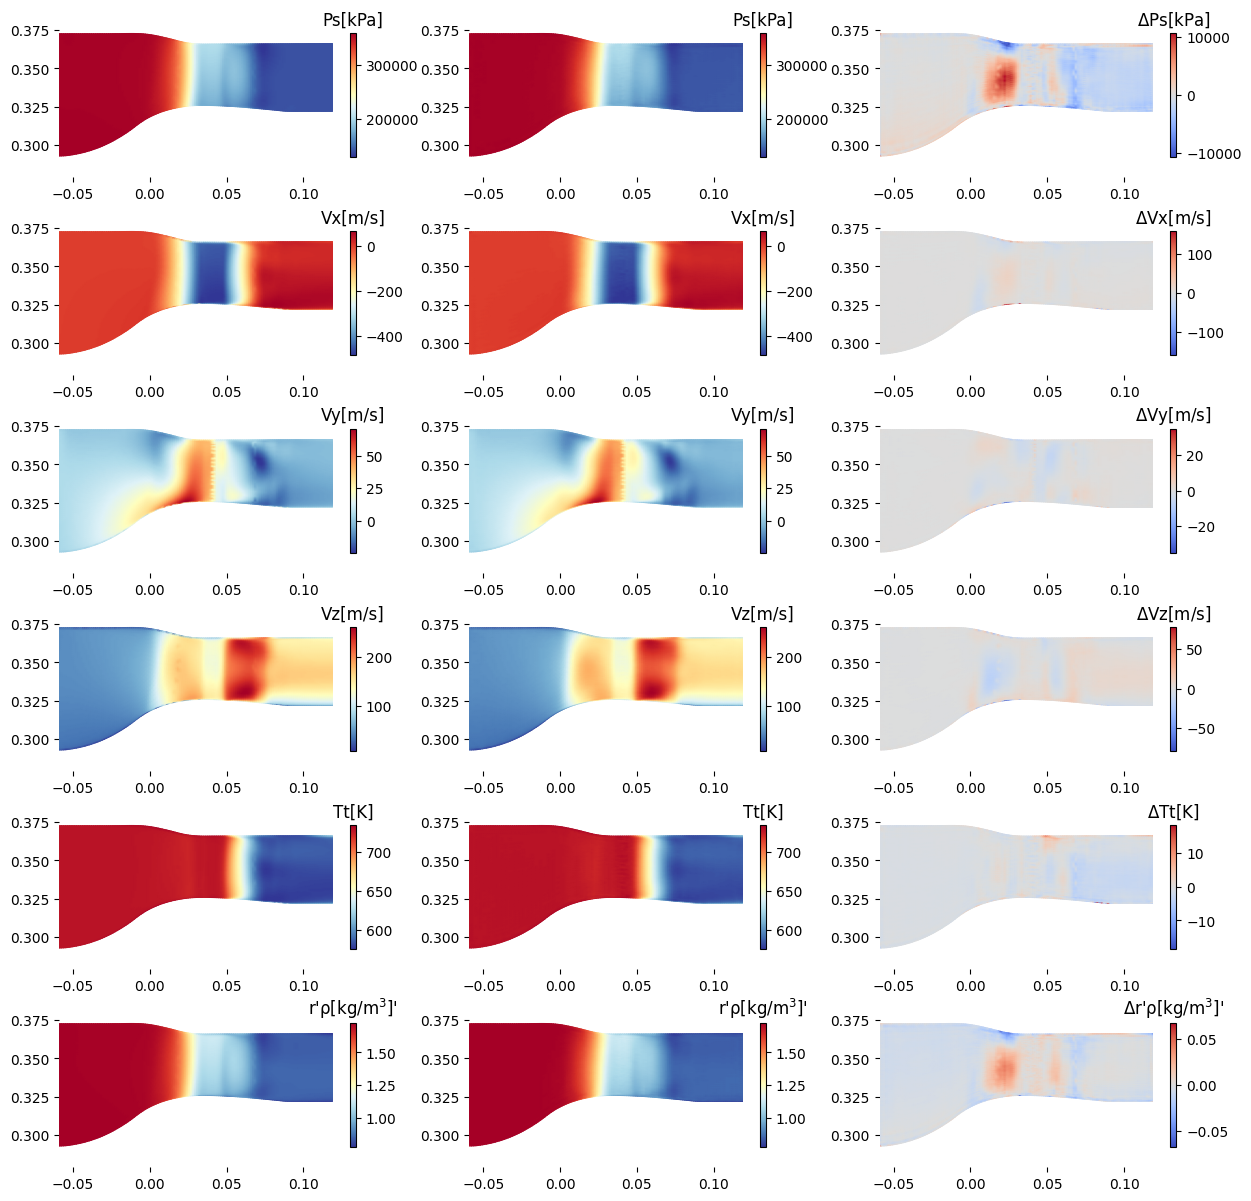

visualizing done!


In [15]:
from src import run_visualization
print_log("visualizing...")
run_visualization(record, save_path='show')
print_log("visualizing done!")

### 不确定性优化设计

基于上述模型对于任意物理场和性能参数的快速推理能力，可以基于此方法开展以涡轮级为对象的不确定性优化设计。


In [3]:
from src import run_optimization
print_log("optimizing...")
run_optimization(record, optimize_type='dtm')
run_optimization(record, optimize_type='uq')
print_log("optimizing done!")

optimizing...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       32 | -9.030525E-01 | -9.115601E-01
     2 |       64 | -9.068705E-01 | -9.129156E-01
     3 |       96 | -9.078698E-01 | -9.129156E-01
     4 |      128 | -9.087827E-01 | -9.129156E-01
     5 |      160 | -9.095835E-01 | -9.133197E-01
     6 |      192 | -9.100327E-01 | -9.153641E-01
     7 |      224 | -9.102122E-01 | -9.153641E-01
     8 |      256 | -9.104855E-01 | -9.153641E-01
     9 |      288 | -9.107386E-01 | -9.153641E-01
    10 |      320 | -9.109671E-01 | -9.153641E-01
    11 |      352 | -9.115191E-01 | -9.156155E-01
    12 |      384 | -9.118710E-01 | -9.156155E-01
    13 |      416 | -9.121323E-01 | -9.156155E-01
    14 |      448 | -9.122287E-01 | -9.156155E-01
    15 |      480 | -9.124259E-01 | -9.156155E-01
    16 |      512 | -9.125562E-01 | -9.156155E-01
    17 |      544 | -9.126345E-01 | -9.156155E-01
    18 |      576 | -9.130733E-01 | -9.193877E-01
    19 |      608 | -9.133192E-01 | 